# Map views
Using data from the data processing step (https://github.com/sztelzer/Bike-Riding-Analysis/blob/master/Data%20Processing.md), we can now test various plot types of the data.

In [25]:
import pickle as pk
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection

def save_data(data, name):
    cache = open(name+".pkl", 'wb')
    pk.dump(data, cache)
    cache.close()
    
def load_data(name):
    cache = open(name+".pkl", 'rb')
    data = pk.load(cache)
    cache.close()
    return data

### Reduction functions

In [190]:
def reducetime(data, N=10):
    data = data.groupby(['rider', 'ride']).apply(timereducer, N)
    return data
    
def timereducer(ride, N):
    breaks = np.arange(N-1, len(ride), N)
    groups = np.split(ride, breaks)
    vectors = pd.concat(list(map(firsttolast, groups)))
    return vectors

def firsttolast(ride):
    vector = ride.head(1)
    tail = vector.tail(1)
    vector.flon = tail.flon
    vector.flat = tail.flat
    vector.felev = tail.felev
    vector.ftime = tail.ftime
    vector.dist = haversine(vector.ilon, vector.ilat, vector.flon, vector.flat)
    vector.heading = np.arctan2(vector.flon-vector.ilon, vector.flat-vector.ilat) * 180 / np.pi
    return vector
    
def reducespace(rides, R):
    rides['glon'] = np.around(rides.ilon, R)
    rides['glat'] = np.around(rides.ilat, R)
    rides['gdir'] = (rides.heading/90).astype(np.int)*90
    vectors = rides.groupby(['gdir', 'glon', 'glat']).mean()
    return vectors

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    return 6372800 * 2 * np.arcsin(np.sqrt(a))

def clearvectors(vecs):
    return vecs

In [178]:
cachefile = open("grouped.pkl", 'rb')
data = pk.load(cachefile)
cachefile.close()

data = data[data.ilat > -23.63] #east boundary
data = data[data.ilat < -23.50] #west boundary
data = data[data.ilon > -46.76] #north boundary
data = data[data.ilon < -46.60] #south boundary

(11533, 16)
(1154, 16)


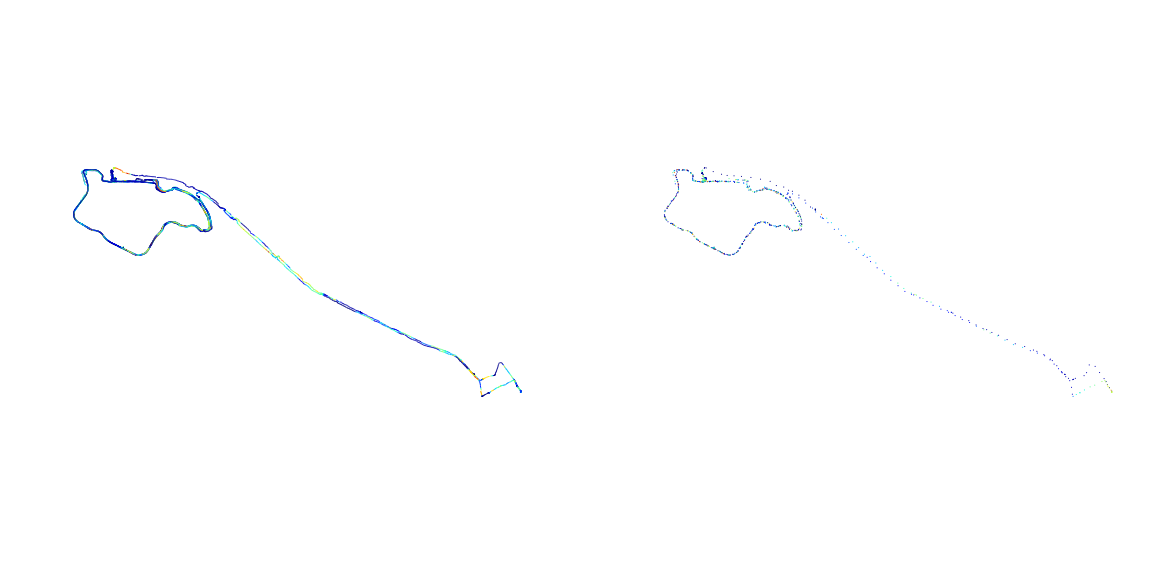

In [197]:
minidata = data.loc[0].loc[1]
print(minidata.shape)

microdata = reducetime(minidata)
print(microdata.shape)

# nanodata = reducespace(microdata, 4)
# print(nanodata.shape)

plt.figure(figsize=(30,10))
plt.subplot(131).quiver(minidata.ilon, minidata.ilat, minidata.flon-minidata.ilon, minidata.flat-minidata.ilat, color=rgba, units='xy', angles='xy', scale=1, pivot='tail')
plt.axis('equal')
plt.axis('off')
plt.subplot(132).quiver(microdata.ilon, microdata.ilat, microdata.flon-microdata.ilon, microdata.flat-microdata.ilat, color=rgba, units='xy', angles='xy', scale=1, pivot='tail')
plt.axis('equal')
plt.axis('off')
# plt.subplot(133).quiver(nanodata.ilon, nanodata.ilat, nanodata.flon-nanodata.ilon, nanodata.flat-nanodata.ilat, color=rgba, units='xy', angles='xy', scale=1, pivot='tail')
# plt.axis('equal')
# plt.axis('off')


plt.show()


# Quiver, Scatter and Line Collection.
Quiver plots an arrows field, but should use simplifications to have less vectors.
Scatter plots are easy, disconnected, but also just points.
Line Collection are the best, but a little more complicated.

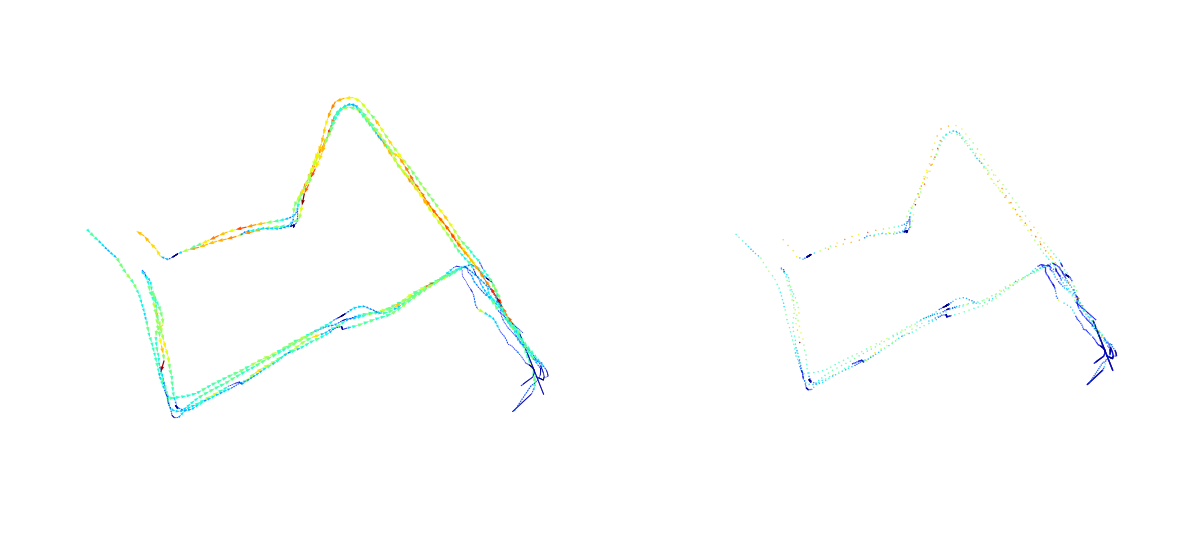

In [42]:
n = 200
c = data.loc[0].loc[0].head(n)
c = c.append(data.loc[0].loc[0].tail(n))
c = c.append(data.loc[0].loc[1].head(n//2))
c = c.append(data.loc[0].loc[1].tail(n))
c = c.append(data.loc[0].loc[2].head(n))
c = c.append(data.loc[0].loc[2].tail(n))
c = c.append(data.loc[0].loc[4].head(n//2))
c = c.append(data.loc[0].loc[4].tail(n))
norm = colors.Normalize()
cmap = plt.cm.get_cmap('jet')
rgba = cmap(norm(c.dist))

plt.figure(figsize=(20,20))
plt.subplot(221).quiver(c.ilon, c.ilat, c.flon-c.ilon, c.flat-c.ilat, color=rgba, units='xy', angles='xy', scale=1, pivot='tail')
plt.axis('equal')
plt.axis('off')

plt.subplot(222).scatter(c.ilon, c.ilat, color=rgba, s=0.2)
plt.axis('equal')
plt.axis('off')
plt.show()

3519833


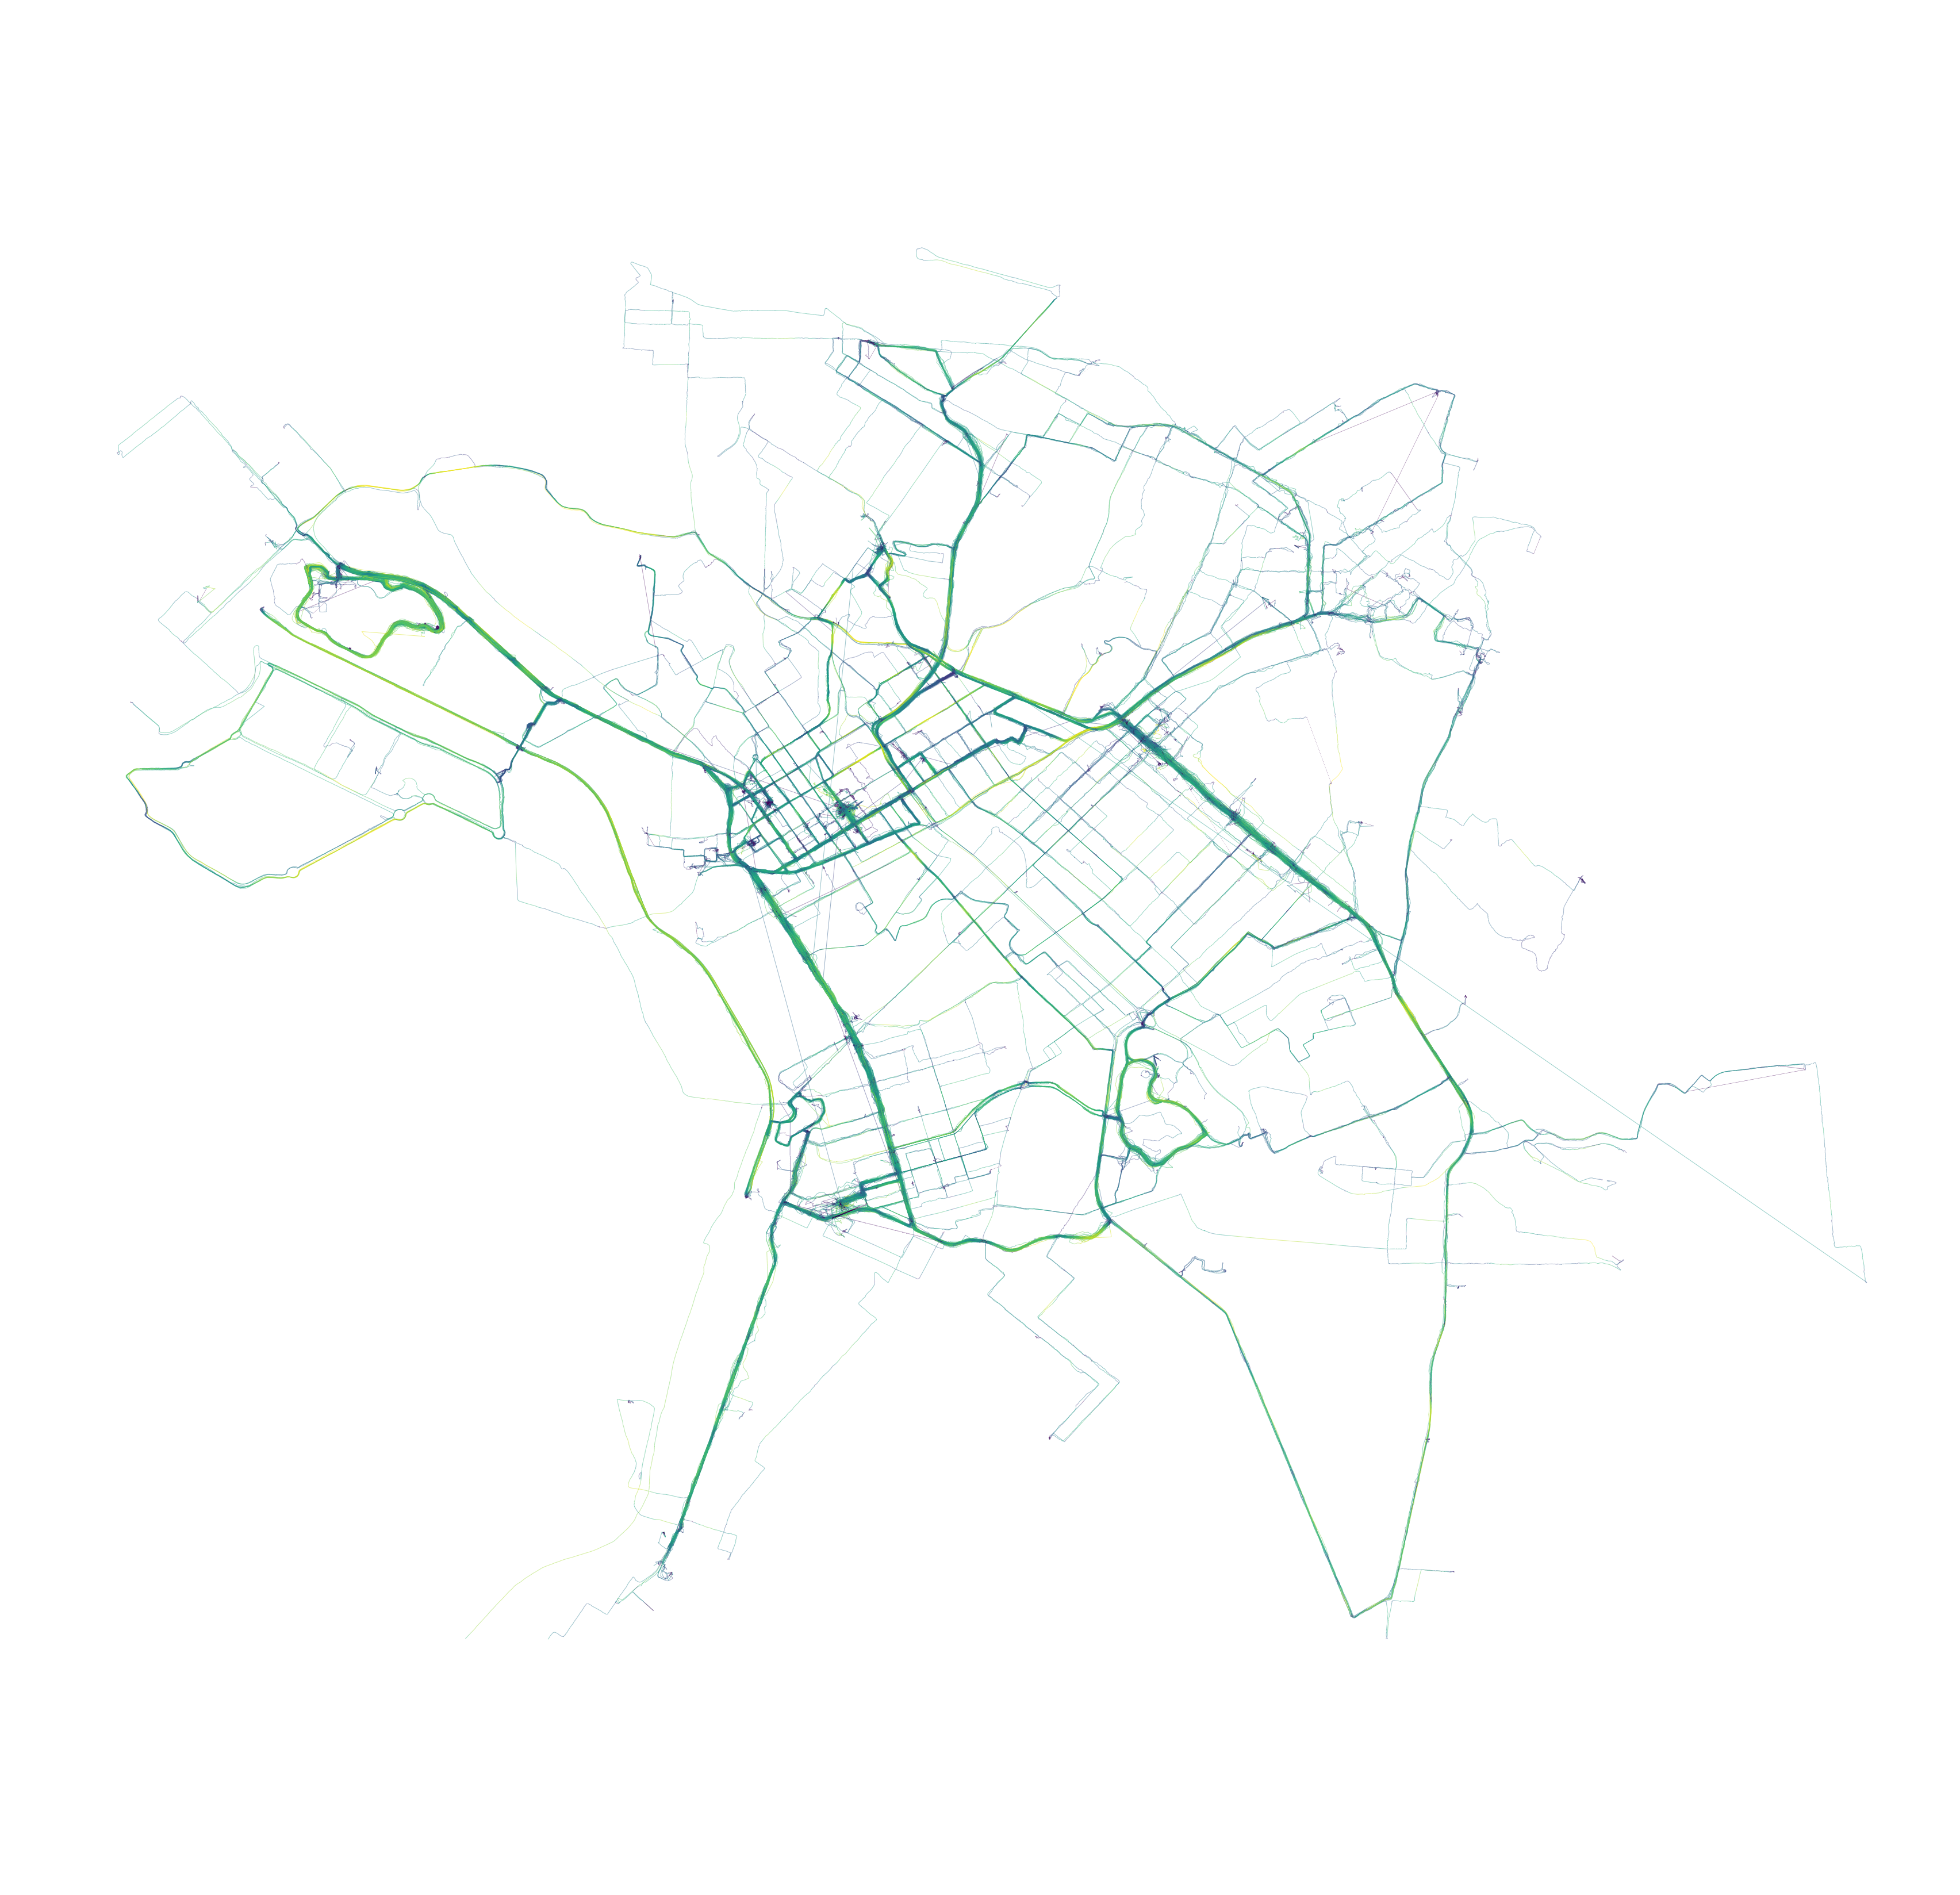

In [214]:
N = 20
c['distmean'] = np.convolve(c.dist, np.ones((N,))/N, mode='same')

c = data
# groups = c[['ilon', 'ilat']].groupby([c.rider, c.ride], as_index=False, squeeze=True)
# xy = list(groups)
# x = []
# for a in range(len(xy)):
#     x.append(np.array(xy[a][1]))

x = list(zip(zip(c.ilon, c.ilat), zip(c.flon, c.flat)))
print(len(x))

g, ax = plt.subplots(figsize=(60,60))
collection = LineCollection(x, linewidth=1, alpha=0.5)
collection.set_array(norm(c.distmean))

ax.add_collection(collection)
ax.autoscale_view()
ax.axis('equal')
plt.axis('off')
plt.show()

# Scaling to directions vectors

Group all data in one region/direction to a single vector.
1. Sum N sequential points to one vector.
2. Average the vectors in the same field region with the same direction.

In [44]:
s = data
print(s.shape)
s = reduceTime(s, 100)
print(s.shape)
s = reduceSpace(s)
print(s.shape)
s = clearVectors(s)
print(s.shape)

(3519833, 16)
(35199, 16)
(285, 16)
(285, 16)


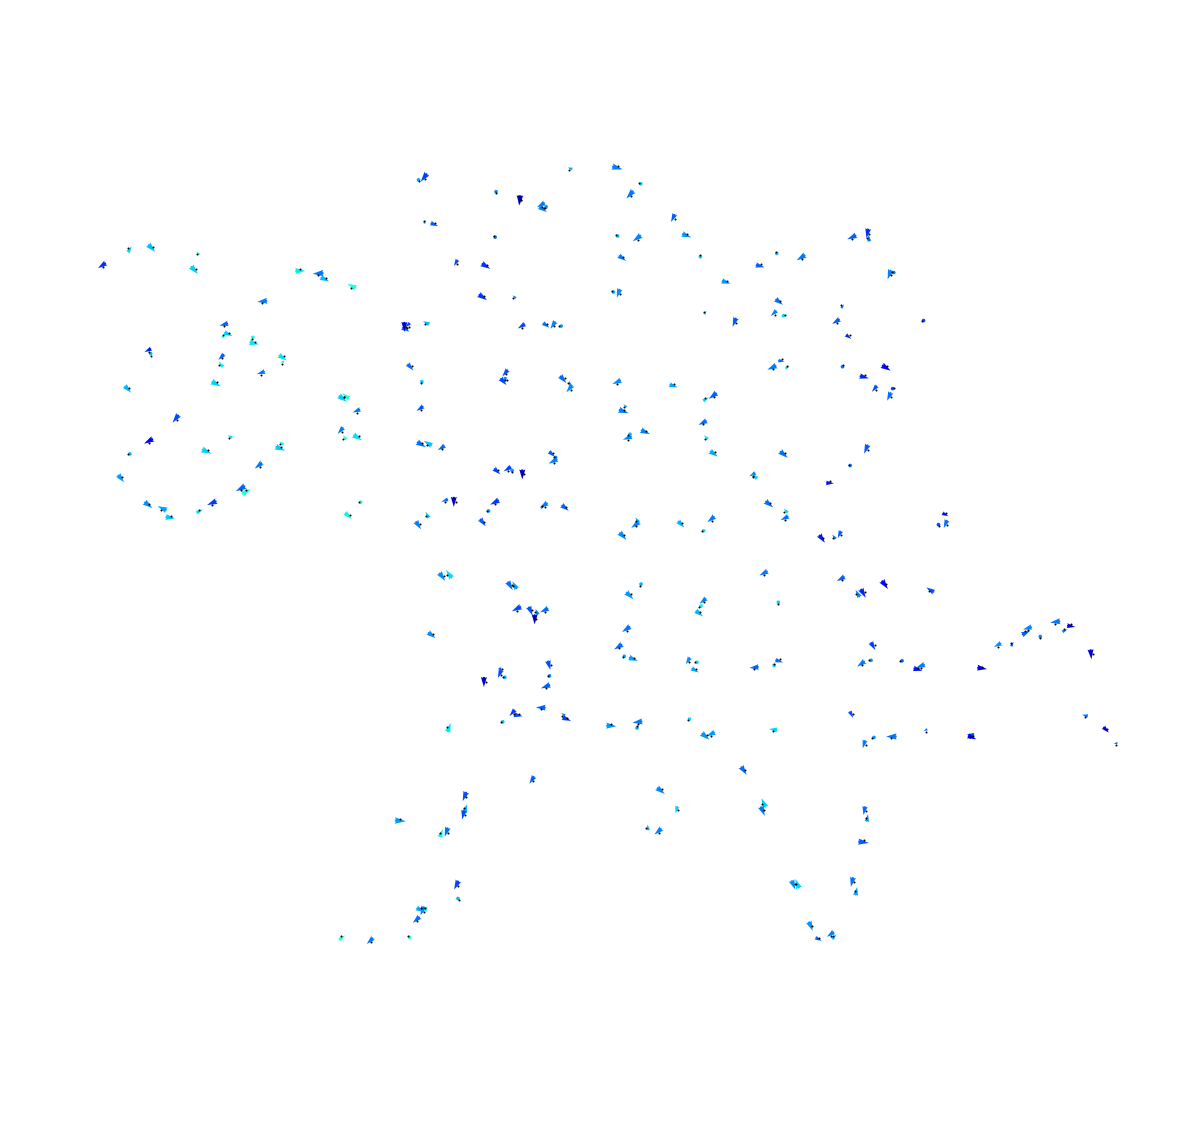

In [49]:
s['distmean'] = np.convolve(s.dist, np.ones((N,))/N, mode='same')
g, ax = plt.subplots(figsize=(20,20))
u = (s.flon-s.ilon)/s.dist
v = (s.flat-s.ilat)/s.dist
mov = 0.00025
x = s.ilon + (np.cos(np.arctan2(u, v)) * mov)
y = s.ilat + (-np.sin(np.arctan2(u, v)) * mov)
plt.quiver(x, y, u, v, color=cmap(norm(s.distmean)), scale=0.001, pivot='mid')
plt.scatter(s.ilon, s.ilat, s=1, color="black", alpha=1)
ax.autoscale_view()
ax.axis('equal')
plt.axis('off')
plt.show()

